In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
train_folder = '/kaggle/input/intel-image-classification/seg_train/seg_train/'

In [3]:
import os

In [4]:
#find number of files in train folder
n = 0
for _, _, filenames in os.walk(train_folder):
    for filename in filenames:
        n += 1

In [5]:
n

14034

In [6]:
ds_filelist_train = tf.data.Dataset.list_files(file_pattern = train_folder + '*/*', shuffle = False)

In [7]:
ds_filelist_train = ds_filelist_train.shuffle(buffer_size = n, reshuffle_each_iteration = False)

In [8]:
table = tf.lookup.StaticHashTable(tf.lookup.KeyValueTensorInitializer(tf.constant(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']), tf.range(6)), -1)
def load_imgs(filepath):
    img = tf.io.read_file(filepath)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [150, 150])
    
    tag = tf.strings.split(filepath, os.path.sep)[-2]

    label = table.lookup(tag)
    
    return img, label

In [9]:
ds_train = ds_filelist_train.map(load_imgs, num_parallel_calls = tf.data.experimental.AUTOTUNE)

In [10]:
def img_augmentation(img, label):
    #img = tf.image.random_contrast(img, 0.1, 0.9)
    #img = tf.image.random_hue(img, 0.5)
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_crop(img, (125, 125, 3))
    return tf.image.resize(img, (150, 150)), label

In [11]:
ds_train = ds_train.map(img_augmentation, num_parallel_calls = tf.data.experimental.AUTOTUNE)

In [12]:
for i in ds_train.take(1):
    print(i)

(<tf.Tensor: shape=(150, 150, 3), dtype=float32, numpy=
array([[[0.3529412 , 0.4666667 , 0.20784315],
        [0.19705883, 0.31078434, 0.05784314],
        [0.49281043, 0.60424834, 0.36470586],
        ...,
        [0.03398689, 0.06013064, 0.13823527],
        [0.09607844, 0.13627452, 0.19705883],
        [0.25490198, 0.30980393, 0.3529412 ]],

       [[0.60588235, 0.6990197 , 0.4519608 ],
        [0.40808827, 0.5056373 , 0.2644608 ],
        [0.3518791 , 0.45204252, 0.22426471],
        ...,
        [0.03153592, 0.06478751, 0.13651958],
        [0.04828431, 0.09730393, 0.15514706],
        [0.08137255, 0.14509803, 0.18529412]],

       [[0.504902  , 0.5957517 , 0.37549025],
        [0.45955884, 0.5545752 , 0.33161765],
        [0.46960783, 0.5709695 , 0.34654137],
        ...,
        [0.02805001, 0.07072423, 0.1325162 ],
        [0.04093137, 0.09861112, 0.14803922],
        [0.00980392, 0.05816994, 0.09509805]],

       ...,

       [[0.36568603, 0.33725467, 0.33888867],
        [0.3

#Build the CNN Model
model = tf.keras.Sequential() #input (150, 150, 3)
model.add(tf.keras.layers.Conv2D(filters = 27, kernel_size = 2, padding = 'same', activation = 'relu', input_shape = (150, 150, 3))) #result in (150, 150, 27)
model.add(tf.keras.layers.MaxPool2D(pool_size = 5)) #result in (30, 30, 27)
model.add(tf.keras.layers.Dropout(0.2)) #Drop out prob 20%
model.add(tf.keras.layers.Conv2D(filters = 54, kernel_size = 5, padding = 'same')) #result in (30, 30, 54)
model.add(tf.keras.layers.MaxPool2D(pool_size = 5)) #result in (6, 6, 54)
model.add(tf.keras.layers.Flatten()) #Flatten to 6 * 6 * 54
model.add(tf.keras.layers.Dense(100, activation = 'relu')) # 100
model.add(tf.keras.layers.Dropout(0.5)) #Drop out prob 50%
model.add(tf.keras.layers.Dense(6)) # number of outputs = 6

model.summary()

model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics = ['accuracy'])

In [13]:
#Tranfer Learning using InceptionV3
Inception_v3 = tf.keras.applications.InceptionV3(include_top = False, input_shape = (150, 150, 3), weights = None)

#load weights
local_weights_file = '/kaggle/input/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
Inception_v3.load_weights(local_weights_file)

In [14]:
Inception_v3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [15]:
#freeze layers
for layer in Inception_v3.layers:
    layer.trainable = False

In [16]:
#get last layer
last_layer = Inception_v3.layers[-1]
print(last_layer.output_shape)
last_output = last_layer.output

(None, 3, 3, 2048)


In [17]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(6)(x)

model = tf.keras.Model(inputs = Inception_v3.input, outputs = x)

In [18]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics = ['accuracy'])

In [19]:
#Prepare the data for training
ds_train_orig = ds_train
ds_train = ds_train_orig.take(13000)
ds_valid = ds_train_orig.skip(13000)

#shuffle, batch
ds_train = ds_train.shuffle(n).batch(20).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
ds_valid = ds_valid.batch(20).cache().prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

In [20]:
#Adding Callbacks
callback_1 = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3, verbose = 1)
callback_2 = tf.keras.callbacks.ModelCheckpoint(filepath = '/kaggle/working/model_checkpoints/checkpoint_{epoch}.ckpt', save_weights_only = True, verbose = 1)

In [21]:
history = model.fit(ds_train, epochs = 20, validation_data = ds_valid, callbacks = [callback_1, callback_2])

Epoch 1/20
649/650 [============================>.] - ETA: 0s - loss: 2.2395 - accuracy: 0.7978
Epoch 00001: saving model to /kaggle/working/model_checkpoints/checkpoint_1.ckpt
650/650 [==============================] - 34s 52ms/step - loss: 2.2364 - accuracy: 0.7981 - val_loss: 1.0471 - val_accuracy: 0.7998
Epoch 2/20
649/650 [============================>.] - ETA: 0s - loss: 0.6406 - accuracy: 0.8482
Epoch 00002: saving model to /kaggle/working/model_checkpoints/checkpoint_2.ckpt
650/650 [==============================] - 21s 32ms/step - loss: 0.6398 - accuracy: 0.8482 - val_loss: 0.7388 - val_accuracy: 0.8578
Epoch 3/20
649/650 [============================>.] - ETA: 0s - loss: 0.5887 - accuracy: 0.8582
Epoch 00003: saving model to /kaggle/working/model_checkpoints/checkpoint_3.ckpt
650/650 [==============================] - 21s 32ms/step - loss: 0.5883 - accuracy: 0.8582 - val_loss: 0.6666 - val_accuracy: 0.8781
Epoch 4/20
649/650 [============================>.] - ETA: 0s - loss: 

In [22]:
hist = history.history

Text(0.5, 1.0, 'Training vs. Val Accuracy')

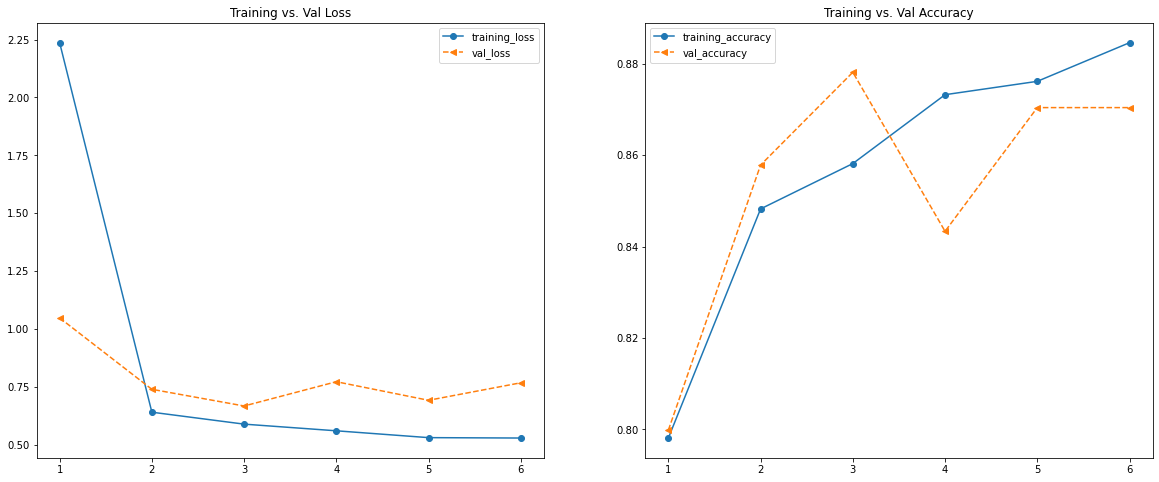

In [23]:
epochs = np.arange(len(hist['loss'])) + 1

fig, ax = plt.subplots(1, 2, figsize = (20, 8))

ax[0].plot(epochs, hist['loss'], '-o', label = 'training_loss')
ax[0].plot(epochs, hist['val_loss'], '--<', label = 'val_loss')
ax[0].legend()
ax[0].set_title('Training vs. Val Loss')

ax[1].plot(epochs, hist['accuracy'], '-o', label = 'training_accuracy')
ax[1].plot(epochs, hist['val_accuracy'], '--<', label = 'val_accuracy')
ax[1].legend()
ax[1].set_title('Training vs. Val Accuracy')


In [24]:
test_folder = '/kaggle/input/intel-image-classification/seg_test/seg_test/'
ds_filelist_test = tf.data.Dataset.list_files(file_pattern = test_folder + '*/*', shuffle = False)
ds_test = ds_filelist_test.map(load_imgs, num_parallel_calls = tf.data.experimental.AUTOTUNE)

In [25]:
ds_test = ds_test.batch(20)

In [26]:
model.evaluate(ds_test)

150/150 [==============================] - 5s 36ms/step - loss: 0.6218 - accuracy: 0.8893


[0.6217800974845886, 0.8893333077430725]

In [27]:
ds_sample = ds_test.unbatch().shuffle(n, reshuffle_each_iteration = False).batch(10).take(1)

In [28]:
pred = model.predict(ds_sample)

In [29]:
pred_prob = tf.nn.softmax(pred, axis = 1)
pred_label = tf.math.argmax(pred_prob, axis = 1)
pred_label_prob = tf.math.reduce_max(pred_prob, axis = 1)

In [30]:
rev_table = tf.lookup.StaticHashTable(tf.lookup.KeyValueTensorInitializer(tf.range(6), tf.constant(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'])), 'x')
pred_tag = rev_table.lookup(tf.cast(pred_label, tf.int32))

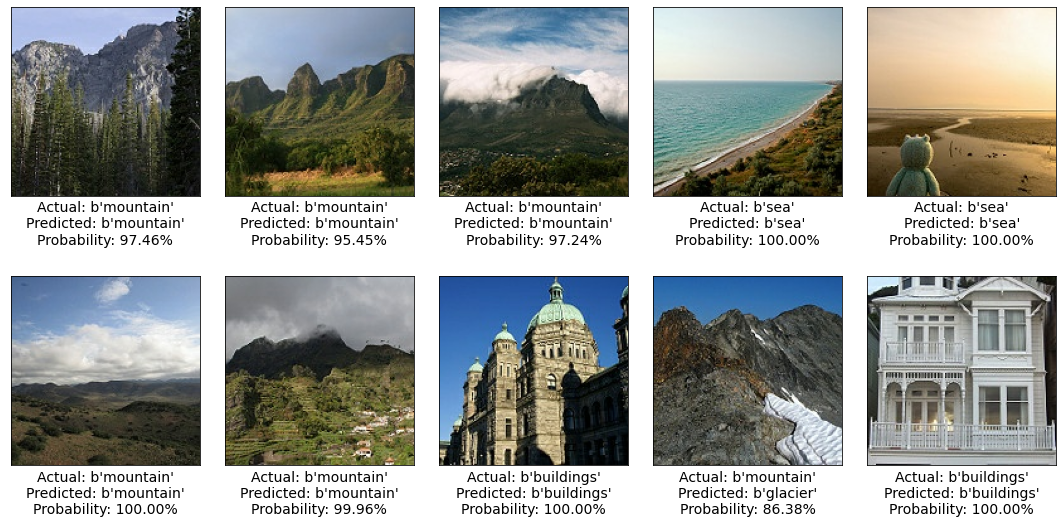

In [31]:
fig = plt.figure(figsize = (15, 8))
for i, sample in enumerate(ds_sample.unbatch()):
    img = sample[0]
    ax = fig.add_subplot(2, 5, i + 1)
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    
    actual_tag = rev_table.lookup(sample[1])
    ax.text(0.5, -0.15, f'Actual: {actual_tag.numpy()}\nPredicted: {pred_tag[i].numpy()}\nProbability: {pred_label_prob[i].numpy():.2%}',
            size = 14, horizontalalignment = 'center', verticalalignment = 'center', transform = ax.transAxes)
    
plt.tight_layout()
plt.show()